Sveučilište u Zagrebu  
Fakultet elektrotehnike i računarstva  
  
## Uvod u znanost o podacima

------------------------------

### Projektni zadatak: Poboljšanje rezultata

*Verzija: 1.0
Zadnji put ažurirano: 7. 1. 2024.* 

Autori: **Stella Balić, Matija Pavlović, Fran Žužić**

------------------------------

## Uvod

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, hinge_loss, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder

import warnings
warnings.filterwarnings('ignore')

In [3]:
X = pd.read_csv("processed_data.csv")
print("Skup podataka sadrži {} primjera s {} značajki".format(X.shape[0], X.shape[1]))

Skup podataka sadrži 569 primjera s 18 značajki


In [4]:
X.head()

,diagnosis,radius_mean,texture_mean,smoothness_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,texture_se,perimeter_se,smoothness_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,0.11840,0.14710,0.2419,0.07871,0.9053,8.589,0.006399,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.4601,0.11890
1,M,20.57,17.77,0.08474,0.07017,0.1812,0.05667,0.7339,3.398,0.005225,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.2750,0.08902
2,M,19.69,21.25,0.10960,0.12790,0.2069,0.05999,0.7869,4.585,0.006150,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.3613,0.08758
3,M,11.42,20.38,0.14250,0.10520,0.2597,0.09744,1.1560,3.445,0.009110,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.6638,0.17300
4,M,20.29,14.34,0.10030,0.10430,0.1809,0.05883,0.7813,5.438,0.011490,0.01885,0.01756,0.005115,0.1374,0.2050,0.4000,0.2364,0.07678


Izvlačimo oznake klasa (M i B) iz prvog stupca i pohranjujemo ih u vektor y.

In [5]:
y = X.iloc[:, 0]
X = X.drop(X.columns[0], axis=1)

# pretvaramo podatke u numpy array
X = X.values
y = y.values.reshape(-1, 1)

Konačno, dijelimo podatke na skup za treniranje i skup za testiranje u omjeru 75/25 koristeći funkciju train_test_split.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75,  test_size=0.25)

## Stroj potpornih vektora

### Optimiranje pretraživanjem po rešetci

U prethodnoj bilježnici razmotrili smo tri različita modela stroja potpornih vektora koji koriste jezgreni trik. Razmotrili smo linearnu, polinomijalnu jezgru stupnja 3 i RBF jezgru (Gaussovu jezgru). Optimalni model smo odabrali na temelju najveće točnosti tj. najmanjeg očekivanja gubitka zglobnice. Vrijednosti hiperparametara ostavili smo na pretpostavljenim vrijednostima koje implementiraju jezgre.

U ovom poglavlju optimirat ćemo upravo te parametre. To su parametar regularizacije **C** i parametar **gamma** u slučaju RBF jezgre koji regulira sličnost primjera.

In [32]:
param_grid = {"C": [0.001, 0.01, 0.1, 0.5, 1, 10], 
              "gamma": [1, 0.75, 0.5, 0.25, 0.1, 0.01], 
              "kernel": ['rbf', 'poly', 'linear']} 

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=5)
grid.fit(X_train, y_train)

best_params = grid.best_params_
print(f"Best params: {best_params}")

optimal_SVC = grid.best_estimator_
#svm_clf = SVC(**best_params)
#svm_clf.fit(X_train, y_train)
y_prediction_test = optimal_SVC.predict(X_test)
loss = hinge_loss(y_test, optimal_SVC.decision_function(X_test))
acc = accuracy_score(y_test, y_prediction_test)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'C': 0.001, 'gamma': 0.5, 'kernel': 'poly'}


In [33]:
acc

0.965034965034965

## Klasifikacija neuronskom mrežom

Neuronske mreže pokazale su se kao dobra supsitucija klasifikacijskih algoritama. U ovom poglavlju razmatramo umjetnu neuronsku mrežu s 5 slojeva. Aktivacijske funkcije ulaznog i skrivenih slojeva je ReLU, a izlanog sloja sigmoida. Funkcija gubitka koju koristimo je gubitak unakrsne entropije za binarnu klasifikaciju. Model treniramo kroz 1000 iteracija. Problem na koji možemo naići je pretreniranost s obzirom da računalna složenost nije problem za vrstu ulaza skupa podataka. Pretreniranost se spriječava redukcijom broja slojeva ili za veliki broj slojeva uvođenjem dropout sloja. U ovom primjeru koristimo što jednostavniju arhitekturu.

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

#torch.manual_seed(0)

input_size = X_train.shape[1]

class TumorNet(nn.Module):
    def __init__(self):
        super(TumorNet, self).__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10) 
        self.layer3 = nn.Linear(in_features=10, out_features=8)
        self.layer4 = nn.Linear(in_features=8, out_features=8)
        #self.layer5 = nn.Linear(in_features=8, out_features=6)
        self.output_layer = nn.Linear(in_features=8, out_features=1)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.activation(self.layer4(x))
        #x = self.activation(self.layer5(x))
        x = self.sigmoid(self.output_layer(x))
        return x

# Inicijalizacija modela, funkcije gubitka i optimizatora 
model = TumorNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Pretvaranje podataka u tenzore
# skup za treniranje
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_encoded = np.where(y_train == "M", 1, 0)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.float32)
# skup za testiranje
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_encoded = np.where(y_test == "M", 1, 0)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.float32)


accuracies_train = []
accuracies_test = []

for iter in range(1000):
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()
    
    if (iter + 1) % 10 == 0:
        train_acc = ((output >= 0.5).float() == y_train_tensor.view(-1, 1)).float().mean()
        accuracies_train.append(train_acc)

        test_output = model(X_test_tensor)
        test_acc = ((test_output >= 0.5).float() == y_test_tensor.view(-1, 1)).float().mean()
        accuracies_test.append(test_acc)

    if (iter + 1) % 100 == 0:
        print(f'Epoch [{iter+1}/1000], Loss: {loss.item():.4f}, Accuracy: {train_acc.item():.4f}')

Epoch [100/1000], Loss: 0.5765, Accuracy: 0.7911
Epoch [200/1000], Loss: 0.2616, Accuracy: 0.8873
Epoch [300/1000], Loss: 0.1797, Accuracy: 0.9319
Epoch [400/1000], Loss: 0.1486, Accuracy: 0.9413
Epoch [500/1000], Loss: 0.1297, Accuracy: 0.9507
Epoch [600/1000], Loss: 0.1146, Accuracy: 0.9624
Epoch [700/1000], Loss: 0.1020, Accuracy: 0.9695
Epoch [800/1000], Loss: 0.0925, Accuracy: 0.9742
Epoch [900/1000], Loss: 0.0855, Accuracy: 0.9765
Epoch [1000/1000], Loss: 0.0803, Accuracy: 0.9789


In [27]:
# Evaluacija modela na testnom skupu podataka
with torch.no_grad():
    model.eval()
    test_output = model(X_test_tensor)
    test_loss = criterion(test_output, y_test_tensor.view(-1, 1))
    test_acc = ((test_output >= 0.5).float() == y_test_tensor.view(-1, 1)).float().mean()

print("TumorNet results on test data:")
print(f"Loss: {test_loss.item():.4f}\nAccuracy: {test_acc.item():.4f}")

TumorNet results on test data:
Loss: 0.0986
Accuracy: 0.9720


Na grafu je prikazana točnost mreže na skupu za treniranje i testiranje u ovisnosti o iteraciji. Točnost je prikazana svaku desetu iteraciju rdi čitljivosti.

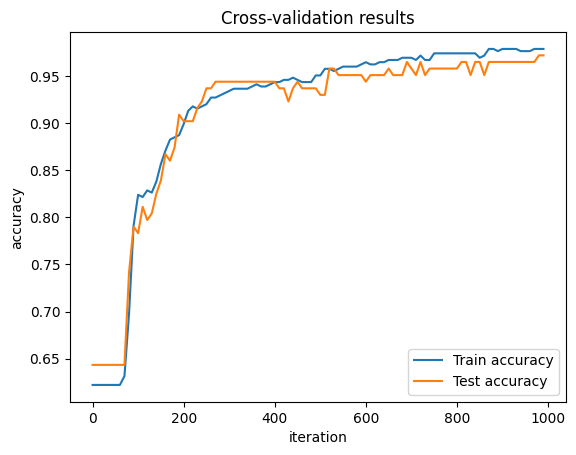

In [28]:
plt.plot(np.arange(0, 1000, 10, dtype=int), accuracies_train, label="Train accuracy")
plt.plot(np.arange(0, 1000, 10, dtype=int), accuracies_test, label="Test accuracy")
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.title("Cross-validation results")
plt.legend()
plt.show()